## Segmentation Transfer

In this notebook we show how to use qFGW to perform matching between models in the ShapeNet and S3DIS datasets

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import ot 
import time
import os
from quantizedGW import * 

In [18]:
from mpl_toolkits.mplot3d import Axes3D

In [19]:
def compress_point_cloud(dists,fdists,p,subset):
    """
    Preprocess pairwise distance matrices into sparse format
    
    """
    row_idx = []
    col_idx = []
    dist_data = []
    fdist_data = []
    set_subset = set(subset)
    
    for ridx,row in enumerate(dists):
        # if at an anchor, send to itself
        if ridx in set_subset:
            cidx = subset.index(ridx)
        else:
            cidx = np.argmin(row)
            
        row_idx.append(ridx)
        col_idx.append(cidx)
        dist_data.append(row[cidx])
        fdist_data.append(fdists[ridx,cidx])
        
    sp_dists = coo_matrix((dist_data, (row_idx, col_idx)),shape=dists.shape) 
    sp_fdists = coo_matrix((fdist_data, (row_idx, col_idx)),shape=fdists.shape) 
    membership = coo_matrix(([1 for v in row_idx], (row_idx, col_idx)),shape=dists.shape)
    p_subset = csr_matrix.dot(p, membership)
    return sp_dists.tocsr(), sp_fdists.tocsr(),membership.tocsr(),p_subset
    

In [20]:
def partition_featurize(data,k=500):
    """
    Randomly sample representatives and create Voronoi partition
    """
    pts = data['pts']
    features = data['features']
    labels = data['labels']    
    subset = sorted(np.random.choice(pts.shape[0],k,replace=False))
    dists  = pairwise_distances(pts,pts[subset,:])
    dists_subset = dists[subset,:]
    fdists = pairwise_distances(features,features[subset,:])
    p = ot.unif(dists.shape[0])
    dists,fdists,membership,p_subset = compress_point_cloud(dists,fdists,p,subset)
    node_subset_idx = subset
    p_subset = renormalize_prob(p_subset)    
    data = {}
    for i in ('features','p','node_subset_idx','labels',
             'dists','fdists','membership','p_subset','dists_subset'):
        data[i] = locals()[i]    
        
    return data    

### ShapeNet

In [21]:
with open('data/airplanes.pkl','rb') as handle:
    airplanes = pickle.load(handle)

In [22]:
dataset = [partition_featurize(v,k=500) for v in airplanes]

In [8]:
%%time
coup = compress_fgw_from_dicts(dataset[0],dataset[1],alpha=0.5,beta=0.5,verbose = False, return_dense = False)

Time for Matching: 8.116177082061768 seconds
CPU times: user 15.2 s, sys: 1.4 s, total: 16.6 s
Wall time: 8.12 s


In [9]:
coup.sum()

1.0

In [10]:
airplanes[0].keys()

dict_keys(['pts', 'features', 'labels'])

In [11]:
tgt_idx = coup.argmax(axis=0).A.flatten()
src = airplanes[0]
tgt = airplanes[1]
df_src = pd.DataFrame(src['pts'])
df_src = df_src.assign(color=src['labels'])
src_col = src['labels']
new_col = np.array([src_col[v] for v in tgt_idx]) #tgt.y.numpy()
df_tgt = pd.DataFrame(tgt['pts'])
df_tgt = df_tgt.assign(color=tgt['labels'])
df_tgt = df_tgt.assign(transfer_color=new_col)
src_fn = f"airplane_src.png"
tgt_fn = f"airplane_tgt.png"
transfer_fn = f"airplane_transfer.png"

In [13]:
fig = plt.figure(dpi=75)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_src[0],df_src[1],df_src[2],c=df_src['color'],cmap='jet')
plt.savefig(src_fn, bbox_inches='tight')

fig = plt.figure(dpi=75)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_tgt[0],df_tgt[1],df_tgt[2],c=df_tgt['color'],cmap='jet')
plt.savefig(tgt_fn, bbox_inches='tight')

fig = plt.figure(dpi=75)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_tgt[0],df_tgt[1],df_tgt[2],c=df_tgt['transfer_color'],cmap='jet')
plt.savefig(transfer_fn, bbox_inches='tight')

AttributeError: 'Axes3D' object has no property 'auto_add_to_figure'

<Figure size 450x300 with 0 Axes>

### S3DIS

In [14]:
with open('data/lobbies.pkl','rb') as handle:
    lobbies = pickle.load(handle)

In [15]:
%%time
dataset = [partition_featurize(v,k=1000) for v in lobbies]

KeyboardInterrupt: 

In [16]:
%%time
coup = compress_fgw_from_dicts(dataset[0],dataset[1],alpha=0.5,beta=0.5,verbose = False, return_dense = False)

Time for Matching: 1.9787490367889404 seconds
CPU times: user 3.4 s, sys: 218 ms, total: 3.62 s
Wall time: 1.98 s


In [17]:
tgt_idx = coup.argmax(axis=0).A.flatten()
src = lobbies[0]
tgt = lobbies[1]
df_src = pd.DataFrame(src['pts'])
df_src = df_src.assign(color=src['labels'])
src_col = src['labels']
new_col = np.array([src_col[v] for v in tgt_idx]) #tgt.y.numpy()
df_tgt = pd.DataFrame(tgt['pts'])
df_tgt = df_tgt.assign(color=tgt['labels'])
df_tgt = df_tgt.assign(transfer_color=new_col)
src_fn = f"lobbies_src.png"
tgt_fn = f"lobbies_tgt.png"
transfer_fn = f"lobbies_transfer.png"

ValueError: Length of values (2578) does not match length of index (909312)

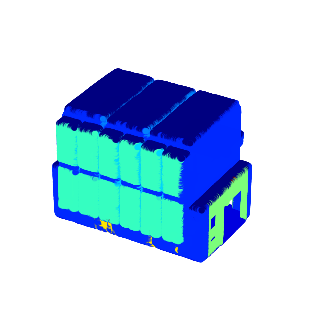

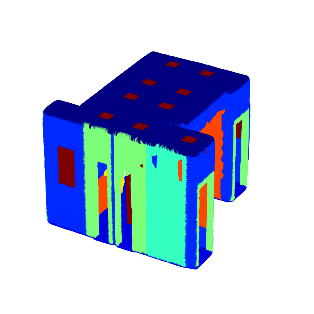

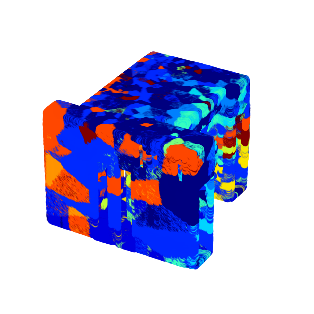

In [48]:
fig = plt.figure(dpi=75)
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_src[0],df_src[1],df_src[2],c=df_src['color'],cmap='jet')
plt.savefig(src_fn, bbox_inches='tight')

fig = plt.figure(dpi=75)
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_tgt[0],df_tgt[1],df_tgt[2],c=df_tgt['color'],cmap='jet')
plt.savefig(tgt_fn, bbox_inches='tight')

fig = plt.figure(dpi=75)
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.patch.set_visible(False)
ax.axis('off')
ax.scatter(df_tgt[0],df_tgt[1],df_tgt[2],c=df_tgt['transfer_color'],cmap='jet')
plt.savefig(transfer_fn, bbox_inches='tight')